<a href="https://colab.research.google.com/github/qmcsuzuki/QMCexamples/blob/main/QMCintegration/QMC_higherorder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qmcpy --quiet
import qmcpy
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def expsum(points,weights,C):
    """
    Args:
      points: N*d ndarray, points to evaluate
      weights: d-dim vector, weights for each dimension
      C: (normalization) constant
    Returns: N-dim vector, exp(sum(w1*x1+...+ws*xs))/C for each point
    """
    return np.exp(np.sum(points*weights,1))/C

def make_normalized_expsum(weights):
    C = np.prod((np.exp(weights)-1)/weights)
    return lambda points: expsum(points,weights,C)

def Bernoulli2(points,weights):
    B2 = (points - 1)*points + 1/6
    return np.prod(1 + weights*B2,1)

def Bernoulli3(points,weights):
    B3 = ((points - 3/2)*points + 1/2)*points
    return np.prod(1 + weights*B3,1)



In [3]:
def interlace_matrices(A, B):
    def spread_bits(n):
        # Spread out the bits of n by introducing zeroes between them
        #n = (n | (n << 32)) & np.uint64(0x00000000FFFFFFFF)
        n = (n | (n << 16)) & np.uint64(0x0000FFFF0000FFFF)
        n = (n | (n << 8)) & np.uint64(0x00FF00FF00FF00FF)
        n = (n | (n << 4)) & np.uint64(0x0F0F0F0F0F0F0F0F)
        n = (n | (n << 2)) & np.uint64(0x3333333333333333)
        n = (n | (n << 1)) & np.uint64(0x5555555555555555)
        return n

    assert A.shape == B.shape
    # Convert doubles to uint64 to manipulate their bit representation
    A_int = (A*(1<<32)).astype(np.uint64)
    B_int = (B*(1<<32)).astype(np.uint64)
    # Apply the interleave_bits_optimized function element-wise
    interlaced = (spread_bits(A_int) << 1) | spread_bits(B_int)
    return interlaced / pow(2.0,64)

def interlace(A):
    return interlace_matrices(A[:,1::2],A[:,::2])


In [4]:
def make_errortable(integrand, Points, Mmax, truevalue=1):
    """ Points の最初の 2^1, ..., 2^{Mmax} 点での，integrand のQMC積分誤差のテーブルを返す
    integrand: 被積分関数
    Points: N*d ndarray (d-dimensional N points)
    """
    error = np.zeros(Mmax)
    for m in range(1,Mmax+1):
        x = np.mean(integrand(Points[:1<<m,:]))
        error[m-1] = np.abs(x-truevalue)
    return error


def make_errorplot(Errors, labels, slopes, savefilename):
    """ Errors の各 Error 配列の中身を loglog プロットする
    Errors: 長さ Mmax の配列のリスト
    labels: 名前のリスト
    slopes: 凡例に表示する傾き
    """
    plt.figure(figsize=(10, 6))
    linestyles = ['-', '--',  ':', '-.']
    markers = ['o', '^', 'x', 'D']

    for i,error in enumerate(Errors):
        plt.semilogy(np.arange(1,Mmax+1), error, color='black', linestyle=linestyles[i], marker=markers[i], markerfacecolor='none', label=labels[i])

    for slope in slopes:
        x = np.arange(1, Mmax+1)
        y = 2.0**(slope*x)
        plt.semilogy(x, y, color='gray', linestyle='--', label=f'Slope={slope}')

    plt.xticks(np.arange(1, Mmax+1, 2),fontsize=16)  # X軸の目盛りを2刻みに
    plt.yticks(fontsize=16)  # Y軸の目盛りを大きく
    plt.xlim(0,Mmax+0.1)
    #plt.ylim(10**-12, 10**0)  # Y軸の範囲を固定
    plt.legend(fontsize=16)

    plt.savefig(savefilename,format="pdf",bbox_inches='tight')
    plt.show()


In [5]:
def experiment(s,Mmax,integrand,savefilename):
    """
    被積分関数 f(x)=integrand  とする
    Sobol, Halton, Random による積分誤差をプロットする
    """
    HOSobol = interlace(qmcpy.Sobol(2*s,randomize=False).gen_samples(1<<Mmax))
    Lattice = qmcpy.Lattice(s,randomize=False).gen_samples(1<<Mmax)
    labels = ["HOSobol'",'Lattice']

    Errors = [make_errortable(integrand, points, Mmax) for points in (HOSobol,Lattice)]
    make_errorplot(Errors, labels, slopes=[-1,-2,-3],savefilename=savefilename)


---

# 実験

$f(x) = \exp(\sum_{j=1}^4 x_j)$ で数値実験を行う。この関数は滑らかだが周期的でない


## 結果

- interlaced Sobol' では $O(N^{-2})$ の収束
- 格子では $O(N^{-1})$ の収束



/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332
/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/lattice/lattice.py:323


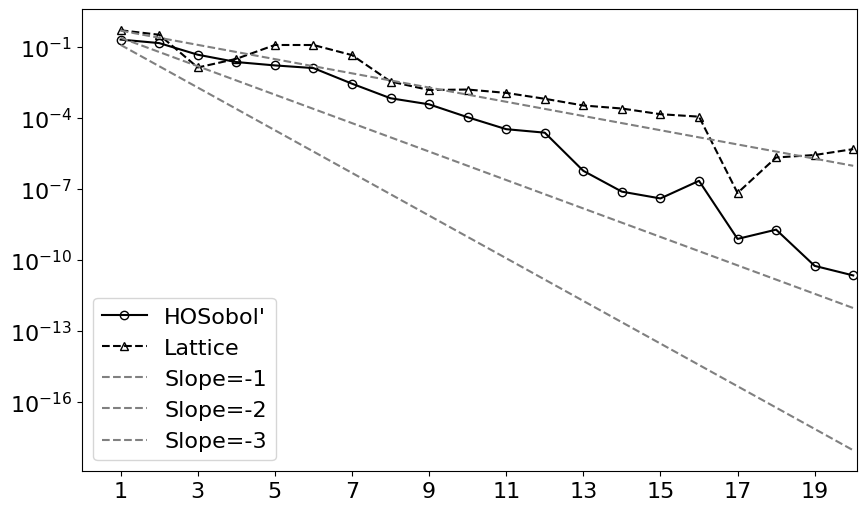

In [6]:
s = 4
Mmax = 20
weights = np.ones(s)
integrand = make_normalized_expsum(weights)
savefilename = f"{s:02}dim_highorder_expsum.pdf"

experiment(s,Mmax,integrand,savefilename)

---

# 実験

$f(x) = \prod_{j=1}^s(1 + B_2(x_j))$ で数値実験を行う。
ここで $B_2$ は $2$ 次のベルヌーイ多項式で、周期的である


## 結果

- interlaced Sobol' では $O(N^{-2})$ の収束
- 格子では $O(N^{-2})$ の収束


/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332
/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/lattice/lattice.py:323


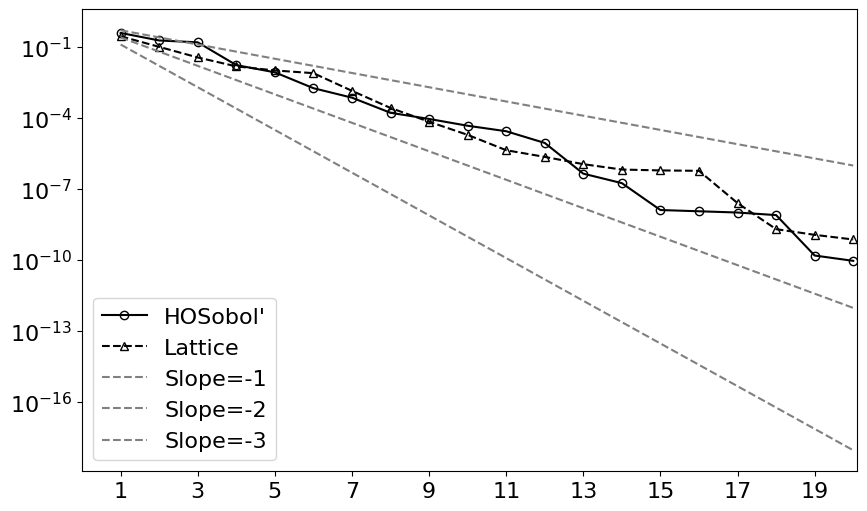

In [7]:
from functools import partial

s = 4
Mmax = 20
weights = np.ones(s)
integrand = partial(Bernoulli2, weights=weights)

savefilename = f"{s:02}dim_highorder_Bernoulli2.pdf"

experiment(s,Mmax,integrand,savefilename)

---

# 実験

$f(x) = \prod_{j=1}^s(1 + B_3(x_j))$ で数値実験を行う。
ここで $B_2$ は $3$ 次のベルヌーイ多項式で、周期的である


## 結果

- interlaced Sobol' では $O(N^{-2})$ の収束
- 格子では $O(N^{-3})$ の収束（収束が頭打ちになるのは精度の限界のためと思われる）


/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/digital_net_b2/digital_net_b2.py:332
/usr/local/lib/python3.10/dist-packages/qmcpy/discrete_distribution/lattice/lattice.py:323


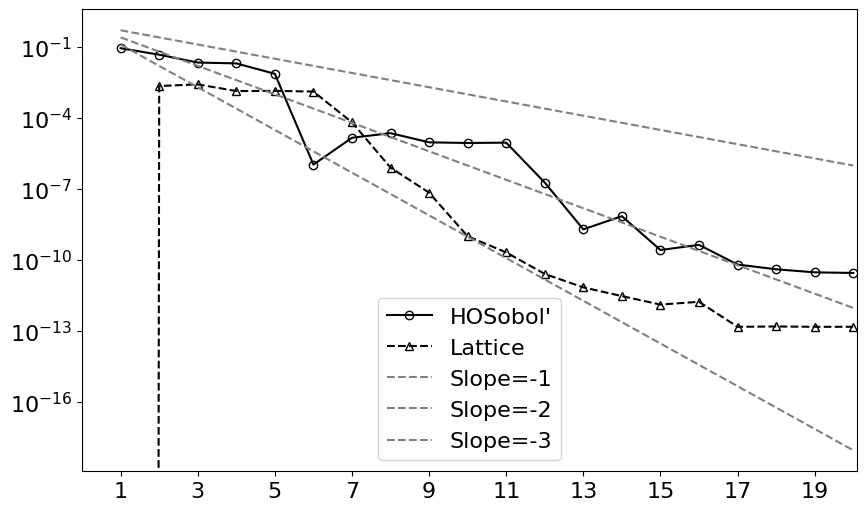

In [8]:
from functools import partial

s = 4
Mmax = 20
weights = np.ones(s)
integrand = partial(Bernoulli3, weights=weights)

savefilename = f"{s:02}dim_highorder_Bernoulli3.pdf"

experiment(s,Mmax,integrand,savefilename)